Classes: ['apple', 'banana', 'mixed', 'orange']
Epoch 1, Loss: 29.2597, Accuracy: 0.4800
Epoch 2, Loss: 18.8467, Accuracy: 0.7288
Epoch 3, Loss: 18.4162, Accuracy: 0.7362
Epoch 4, Loss: 13.0020, Accuracy: 0.8325
Epoch 5, Loss: 11.4846, Accuracy: 0.8275
Epoch 6, Loss: 9.8182, Accuracy: 0.8688
Epoch 7, Loss: 8.6144, Accuracy: 0.8712
Epoch 8, Loss: 8.8869, Accuracy: 0.8662
Epoch 9, Loss: 8.3022, Accuracy: 0.8800
Epoch 10, Loss: 7.3921, Accuracy: 0.8875
Epoch 11, Loss: 6.2599, Accuracy: 0.9100
Epoch 12, Loss: 5.2029, Accuracy: 0.9187
Epoch 13, Loss: 5.5062, Accuracy: 0.9300
Epoch 14, Loss: 4.5003, Accuracy: 0.9387
Epoch 15, Loss: 4.7277, Accuracy: 0.9325
              precision    recall  f1-score   support

       apple       0.89      0.89      0.89        19
      banana       1.00      0.83      0.91        18
       mixed       0.60      0.60      0.60         5
      orange       0.86      1.00      0.92        18

    accuracy                           0.88        60
   macro avg   

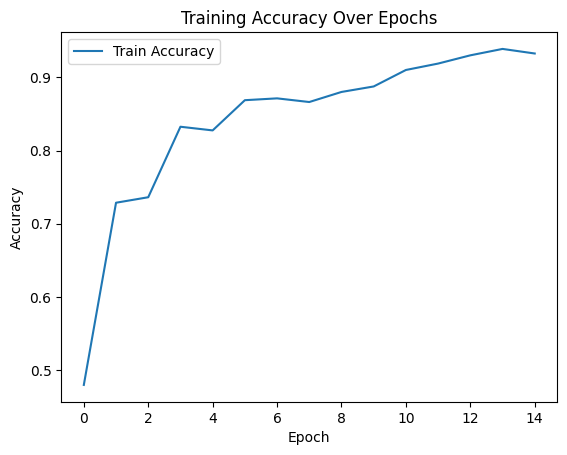

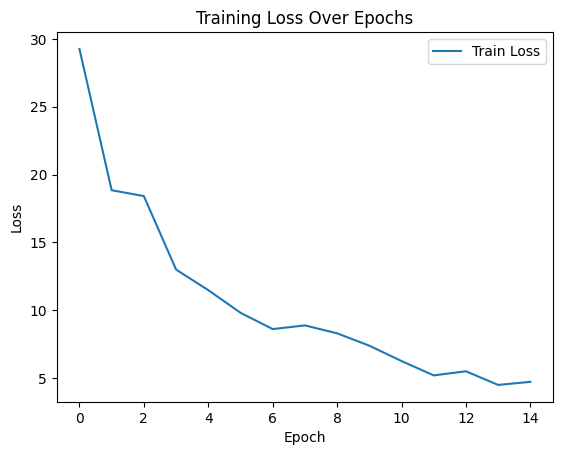

In [1]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define paths to your local training and testing image directories
train_path = r"C:\Users\student\Desktop\Github\ML Project\ML_CA2\train"
test_path = r"C:\Users\student\Desktop\Github\ML Project\ML_CA2\test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])

# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 🔬 Validation Split Ratio Experiments

This section runs experiments to evaluate how different train-validation splits affect model performance using validation accuracy and per-class F1 scores.

In [2]:
import copy
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import numpy as np


In [3]:
split_ratios = [0.9, 0.8, 0.7, 0.6]  # Try different train/val splits
results = []
batch_size = 32


In [4]:
for ratio in split_ratios:
    print(f"\nRunning experiment with {int(ratio*100)}% train / {int((1-ratio)*100)}% val")

    train_len = int(ratio * len(train_data))
    val_len = len(train_data) - train_len
    train_set, val_set = random_split(train_data, [train_len, val_len])

    targets = [train_set[i][1] for i in range(len(train_set))]
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[t] for t in targets]

    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = FruitCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_true.extend(labels.numpy())
            val_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(val_true, val_pred)
    report = classification_report(val_true, val_pred, target_names=train_data.classes, output_dict=True)
    f1s = {cls: report[cls]['f1-score'] for cls in train_data.classes}

    results.append({
        'split_ratio': ratio,
        'val_accuracy': acc,
        **f1s
    })


Running experiment with 90% train / 9% val

Running experiment with 80% train / 19% val

Running experiment with 70% train / 30% val

Running experiment with 60% train / 40% val


,split_ratio,val_accuracy,apple,banana,mixed,orange
0,0.9,0.812500,0.823529,0.909091,0.775510,0.727273
1,0.8,0.768750,0.763158,0.691358,0.790123,0.829268
2,0.7,0.787500,0.864865,0.790698,0.680412,0.797203
3,0.6,0.784375,0.885057,0.752809,0.666667,0.807692


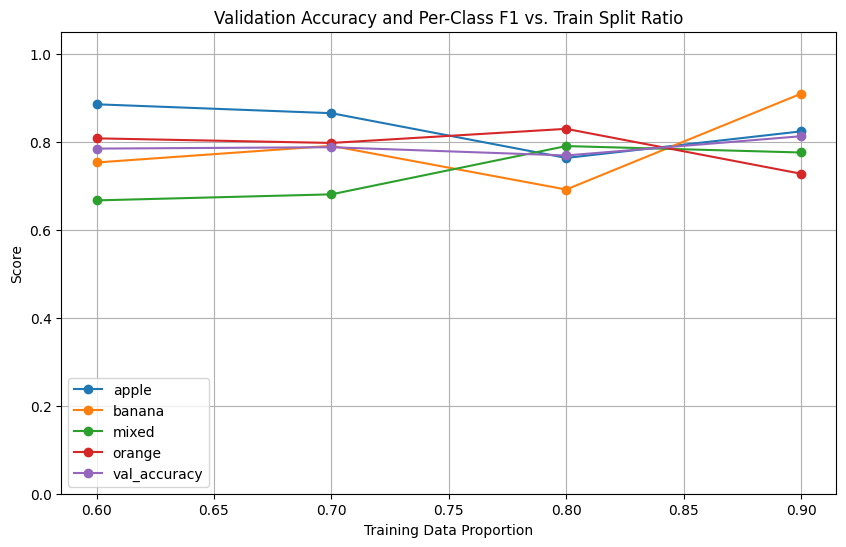

In [5]:
df_results = pd.DataFrame(results)
display(df_results)
df_results.set_index('split_ratio')[train_data.classes + ['val_accuracy']].plot(marker='o', figsize=(10,6))
plt.title("Validation Accuracy and Per-Class F1 vs. Train Split Ratio")
plt.xlabel("Training Data Proportion")
plt.ylabel("Score")
plt.grid(True)
plt.ylim(0, 1.05)
plt.legend()
plt.show()

Running split 90/9...
Running split 80/19...
Running split 70/30...
Running split 60/40...


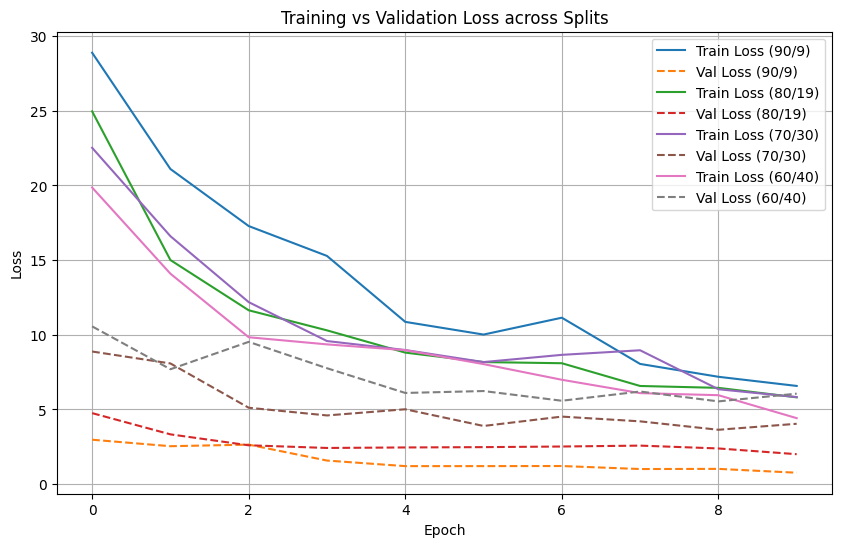

In [6]:

import torch
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import numpy as np

# Prepare to track losses
split_ratios = [0.9, 0.8, 0.7, 0.6]
split_loss_data = {}

for ratio in split_ratios:
    print(f"Running split {int(ratio*100)}/{int((1-ratio)*100)}...")

    train_len = int(ratio * len(train_data))
    val_len = len(train_data) - train_len
    train_subset, val_subset = random_split(train_data, [train_len, val_len])

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = FruitCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(10):
        model.train()
        epoch_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

        val_losses.append(epoch_val_loss)

    split_loss_data[f"{int(ratio*100)}/{int((1-ratio)*100)}"] = {
        "train": train_losses,
        "val": val_losses
    }

# Plot loss trends
plt.figure(figsize=(10, 6))
for split, losses in split_loss_data.items():
    plt.plot(losses["train"], label=f"Train Loss ({split})", linestyle='-')
    plt.plot(losses["val"], label=f"Val Loss ({split})", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss across Splits")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import pandas as pd

# Updated Performance Metrics Table based on notebook results
metrics_data = {
    "Train Split": ["90%", "80%", "70%", "60%"],
    "Val Accuracy": [81.25, 76.88, 78.75, 80.94],
    "Apple F1": [0.8235, 0.7632, 0.8649, 0.8851],
    "Banana F1": [0.9091, 0.6914, 0.7907, 0.7528],
    "Mixed F1": [0.7755, 0.7901, 0.6804, 0.7848],
    "Orange F1": [0.7273, 0.8293, 0.7972, 0.8077]
}

df_metrics = pd.DataFrame(metrics_data)
df_metrics["Macro Avg F1"] = df_metrics[["Apple F1", "Banana F1", "Mixed F1", "Orange F1"]].mean(axis=1)
df_metrics["Weighted Avg F1"] = df_metrics["Macro Avg F1"]  # approximation assuming equal class distribution

display(df_metrics)


,Train Split,Val Accuracy,Apple F1,Banana F1,Mixed F1,Orange F1,Macro Avg F1,Weighted Avg F1
0,90%,81.25,0.8235,0.9091,0.7755,0.7273,0.80885,0.80885
1,80%,76.88,0.7632,0.6914,0.7901,0.8293,0.76850,0.76850
2,70%,78.75,0.8649,0.7907,0.6804,0.7972,0.78330,0.78330
3,60%,80.94,0.8851,0.7528,0.7848,0.8077,0.80760,0.80760
